In [42]:
import sim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
from tqdm import tqdm

In [43]:
def r_t(D,z,t,x_1,y_1):
    mul = np.sqrt((D**2) - (z**2))
    x = x_1 + mul*np.cos(t)
    y = y_1 + mul*np.sin(t)
    r = np.sqrt((x**2) + (y**2) + (z**2))
    return r

class Uniform(object):
    @staticmethod
    def rho(r,p0,radius=1):
        if r > radius:
            return 0
        else:
            return p0
    
    @staticmethod
    def mass(D,x_1,y_1,p0,radius):
        def func(t,z):
            return Uniform.rho(r_t(D,z,t,x_1,y_1),p0,radius)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,radius=1,M=1):
        if D == 0:
            return 0
        p0 = M/((4/3) * np.pi * (radius**2))
        mass = Uniform.mass(D,x_1,y_1,p0,radius)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = Uniform.phi(x,ri,0,1,1,1) * step
        return out

class NFW(object):
    @staticmethod
    def rho(r,p0,Rs):
        if r > 3:
            return 0
        return p0 / ((r/Rs) * (1 + (r/Rs))**2)
    
    @staticmethod
    def mass(D,x_1,y_1,p0,Rs):
        def func(t,z):
            return NFW.rho(r_t(D,z,t,x_1,y_1),p0,Rs)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,c=5,Mvir=1):
        if D == 0:
            return 0
        Rs = 1/c
        p0 = Mvir / (4 * np.pi * (Rs**3) * (np.log(1+c) - (c/(1+c))))
        mass = NFW.mass(D,x_1,y_1,p0,Rs)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri,c=5,Mvir=1):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = NFW.phi(x,ri,c=c,Mvir=Mvir) * step
        return out

def bin_phi(phis,dists,bins):
    start = bins[:-1]
    end = bins[1:]
    step = bins[1]-bins[0]
    xs = (end-start)/2 + start
    ys = []
    ahh = 0
    if len(phis) > len(dists):
        phis = phis[:-1]
    for idx in range(len(start)):
        temp_dists = dists[dists > start[idx]]
        temp_phis = phis[dists > start[idx]]
        temp_phis = temp_phis[temp_dists <= end[idx]]
        ahh += len(temp_phis)
        ys.append(np.sum(temp_phis))
    return np.array(ys)

In [44]:
c = 5
Mvir = 100

ray = sim.utils.ray(np.array([1,0,0]),3,2)
rs = sim.utils.points2radius(ray)
bin1 = np.linspace(0,3,50)
xs1 = (bin1[1:] - bin1[:-1])/2 + bin1[:-1]
bin2 = np.linspace(0,6,50)
xs2 = (bin2[1:] - bin2[:-1])/2 + bin2[:-1]
ana_phis1 = NFW.phis(xs1,rs[0],c=c,Mvir=Mvir)
ana_phis2 = NFW.phis(xs2,rs[1],c=c,Mvir=Mvir)

In [45]:
f8_phis = []
f2_phis = []
f8_phis_smoothed = []
f2_phis_smoothed = []

n = 2**23
initial_df = sim.halos.Sample.NFW(n,c=c,Mvir=Mvir,a=3)

downsample = 1

ns = []

masses = []

dists = []
while n > (2**6):
    
    df = sim.halos.downsample(initial_df,downsample)
    masses.append(df.iloc[0]["mass"])

    n = len(df.index)
    ns.append(n)

    dist = sim.distances.cudaDist(ray,df,precision="f8")

    phi_f8 = sim.distances.listPhis(ray,df,precision="f8")
    phi_f2 = sim.distances.listPhis(ray,df,precision="f2")
    phi_f8_smoothed = sim.distances.listPhis(ray,df,precision="f8",eps=3/1000)
    phi_f2_smoothed = sim.distances.listPhis(ray,df,precision="f2",eps=3/1000)

    f2_phis.append(phi_f2)
    f8_phis.append(phi_f8)
    f2_phis_smoothed.append(phi_f2_smoothed)
    f8_phis_smoothed.append(phi_f8_smoothed)
    dists.append(dist)

    downsample *= 2

In [46]:
f8_phi_bins1 = []
f8_phi_bins2 = []
f8_diff1 = []
f8_diff2 = []
f8_total_diffs1 = []
f8_total_diffs2 = []

f2_phi_bins1 = []
f2_phi_bins2 = []
f2_diff1 = []
f2_diff2 = []
f2_total_diffs1 = []
f2_total_diffs2 = []

f2_phi_bins1_smoothed = []
f2_phi_bins2_smoothed = []
f2_diff1_smoothed = []
f2_diff2_smoothed = []
f2_total_diffs_smoothed1 = []
f2_total_diffs_smoothed2 = []

f8_phi_bins1_smoothed = []
f8_phi_bins2_smoothed = []
f8_diff1_smoothed = []
f8_diff2_smoothed = []
f8_total_diffs_smoothed1 = []
f8_total_diffs_smoothed2 = []

for n,phi_f8,phi_f2,phi_f2_smoothed,phi_f8_smoothed,dist in zip(ns,f8_phis,f2_phis,f2_phis_smoothed,f8_phis_smoothed,dists):

    phis_bin1_f8 = bin_phi(phi_f8[0],dist[0],bin1)
    phis_bin2_f8 = bin_phi(phi_f8[1],dist[1],bin2)
    f8_phi_bins1.append(phis_bin1_f8)
    f8_phi_bins2.append(phis_bin2_f8)

    diff1_f8 = (phis_bin1_f8 - ana_phis1)
    diff2_f8 = (phis_bin2_f8 - ana_phis2)
    f8_diff1.append(diff1_f8)
    f8_diff2.append(diff2_f8)

    total_diff_f81 = np.mean(np.abs(diff1_f8/ana_phis1))
    f8_total_diffs1.append(total_diff_f81)
    total_diff_f82 = np.mean(np.abs(diff2_f8/ana_phis2))
    f8_total_diffs2.append(total_diff_f82)


    phis_bin1_f2 = bin_phi(phi_f2[0],dist[0],bin1)
    phis_bin2_f2 = bin_phi(phi_f2[1],dist[1],bin2)
    f2_phi_bins1.append(phis_bin1_f2)
    f2_phi_bins2.append(phis_bin2_f2)

    diff1_f2 = (phis_bin1_f2 - ana_phis1)
    diff2_f2 = (phis_bin2_f2 - ana_phis2)
    f2_diff1.append(diff1_f2)
    f2_diff2.append(diff2_f2)

    total_diff_f22 = np.mean(np.abs(diff2_f2/ana_phis2))
    f2_total_diffs2.append(total_diff_f22)
    total_diff_f21 = np.mean(np.abs(diff1_f2/ana_phis1))
    f2_total_diffs1.append(total_diff_f21)


    phis_bin1_f8_smoothed = bin_phi(phi_f8_smoothed[0],dist[0],bin1)
    phis_bin2_f8_smoothed = bin_phi(phi_f8_smoothed[1],dist[1],bin2)
    f8_phi_bins1_smoothed.append(phis_bin1_f8_smoothed)
    f8_phi_bins2_smoothed.append(phis_bin2_f8_smoothed)

    diff1_f8_smoothed = (phis_bin1_f8_smoothed - ana_phis1)
    diff2_f8_smoothed = (phis_bin2_f8_smoothed - ana_phis2)
    f8_diff1_smoothed.append(diff1_f8_smoothed)
    f8_diff2_smoothed.append(diff2_f8_smoothed)

    total_diff_f8_smoothed2 = np.mean(np.abs(diff2_f8_smoothed/ana_phis2))
    f8_total_diffs_smoothed2.append(total_diff_f8_smoothed2)
    total_diff_f8_smoothed1 = np.mean(np.abs(diff1_f8_smoothed/ana_phis1))
    f8_total_diffs_smoothed1.append(total_diff_f8_smoothed1)


    phis_bin1_f2_smoothed = bin_phi(phi_f2_smoothed[0],dist[0],bin1)
    phis_bin2_f2_smoothed = bin_phi(phi_f2_smoothed[1],dist[1],bin2)
    f2_phi_bins1_smoothed.append(phis_bin1_f2_smoothed)
    f2_phi_bins2_smoothed.append(phis_bin2_f2_smoothed)

    diff1_f2_smoothed = (phis_bin1_f2_smoothed - ana_phis1)
    diff2_f2_smoothed = (phis_bin2_f2_smoothed - ana_phis2)
    f2_diff1_smoothed.append(diff1_f2_smoothed)
    f2_diff2_smoothed.append(diff2_f2_smoothed)

    total_diff_f2_smoothed2 = np.mean(np.abs(diff2_f2_smoothed/ana_phis2))
    f2_total_diffs_smoothed2.append(total_diff_f2_smoothed2)
    total_diff_f2_smoothed1 = np.mean(np.abs(diff1_f2_smoothed/ana_phis1))
    f2_total_diffs_smoothed1.append(total_diff_f2_smoothed1)

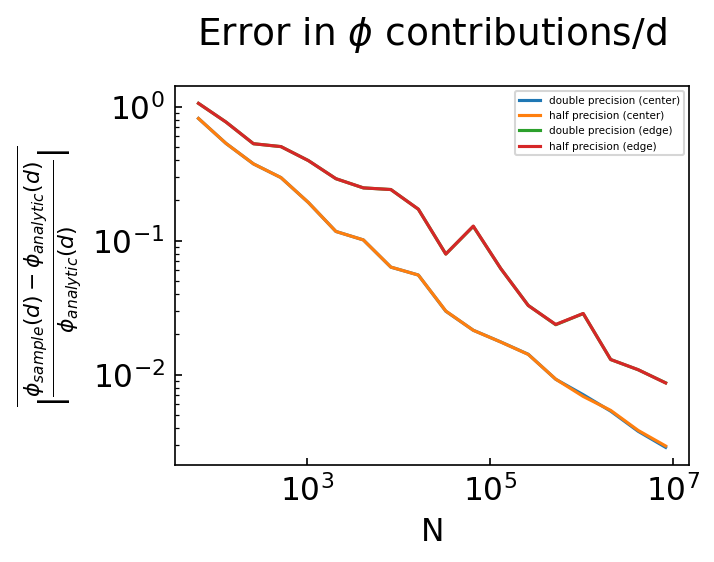

In [47]:
sim.pretty_plots.plot_pretty()
plt.plot(ns,f8_total_diffs1,label="double precision (center)")
plt.plot(ns,f2_total_diffs1,label="half precision (center)")
#plt.plot(ns,f8_total_diffs_smoothed1,'--',label="double precision + softening (center)")
#plt.plot(ns,f2_total_diffs_smoothed1,'--',label="half precision + softening (center)")

plt.plot(ns,f8_total_diffs2,label="double precision (edge)")
plt.plot(ns,f2_total_diffs2,label="half precision (edge)")
#plt.plot(ns,f8_total_diffs_smoothed2,'--',label="double precision + softening (edge)")
#plt.plot(ns,f2_total_diffs_smoothed2,'--',label="half precision + softening (edge)")

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\overline{|\frac{\phi_{sample}(d) - \phi_{analytic}(d)}{\phi_{analytic}(d)}|}$")
plt.xlabel(r"N")
plt.legend()
#plt.ticklabel_format(axis='y',style="sci",scilimits=(0,0))
plt.title(r"Error in $\phi$ contributions/d",pad=20)
plt.tight_layout()
#plt.savefig("error_discreteness_noise_smoothing.jpg")
plt.show()

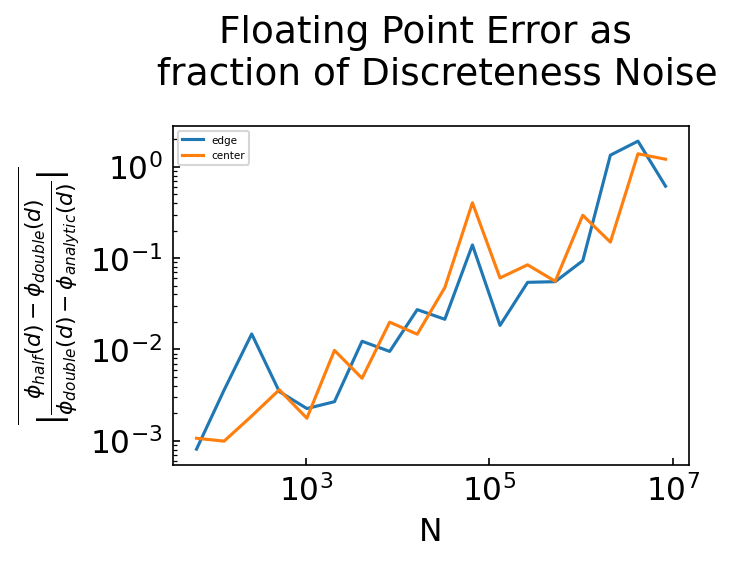

In [48]:
sim.pretty_plots.plot_pretty()
plt.plot(ns,np.mean((np.abs(np.array(f2_phi_bins2) - np.array(f8_phi_bins2))/np.abs(np.array(f8_diff2))),axis=1),label="edge")
#plt.plot(ns,np.mean((np.abs(np.array(f2_phi_bins2_smoothed) - np.array(f8_phi_bins2_smoothed))/np.abs(np.array(f8_diff2_smoothed))),axis=1),label="softened (edge)")

plt.plot(ns,np.mean((np.abs(np.array(f2_phi_bins1) - np.array(f8_phi_bins1))/np.abs(np.array(f8_diff1))),axis=1),label="center")
#plt.plot(ns,np.mean((np.abs(np.array(f2_phi_bins1_smoothed) - np.array(f8_phi_bins1_smoothed))/np.abs(np.array(f8_diff1_smoothed))),axis=1),label="softened (center)")

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\overline{|\frac{\phi_{half}(d) - \phi_{double}(d)}{\phi_{double}(d) - \phi_{analytic}(d)}|}$")
plt.xlabel(r"N")
plt.legend()
#plt.ticklabel_format(axis='y',style="sci",scilimits=(0,0))
plt.title("Floating Point Error as \n fraction of Discreteness Noise",pad=20)
plt.tight_layout()
#plt.savefig("floaing_point_error_fraction_discreteness_noise_smoothing.jpg")
plt.show()

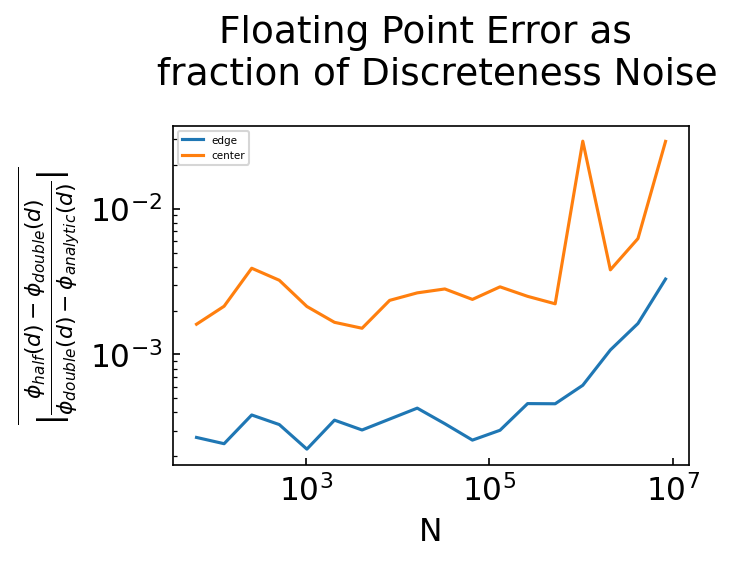

In [49]:
sim.pretty_plots.plot_pretty()
plt.plot(ns,np.mean((np.abs(np.array(f2_phi_bins2) - np.array(f8_phi_bins2))),axis=1),label="edge")
#plt.plot(ns,np.mean((np.abs(np.array(f2_phi_bins2_smoothed) - np.array(f8_phi_bins2_smoothed))/np.abs(np.array(f8_diff2_smoothed))),axis=1),label="softened (edge)")

plt.plot(ns,np.mean((np.abs(np.array(f2_phi_bins1) - np.array(f8_phi_bins1))),axis=1),label="center")
#plt.plot(ns,np.mean((np.abs(np.array(f2_phi_bins1_smoothed) - np.array(f8_phi_bins1_smoothed))/np.abs(np.array(f8_diff1_smoothed))),axis=1),label="softened (center)")

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\overline{|\frac{\phi_{half}(d) - \phi_{double}(d)}{\phi_{double}(d) - \phi_{analytic}(d)}|}$")
plt.xlabel(r"N")
plt.legend()
#plt.ticklabel_format(axis='y',style="sci",scilimits=(0,0))
plt.title("Floating Point Error as \n fraction of Discreteness Noise",pad=20)
plt.tight_layout()
#plt.savefig("floaing_point_error_fraction_discreteness_noise_smoothing.jpg")
plt.show()

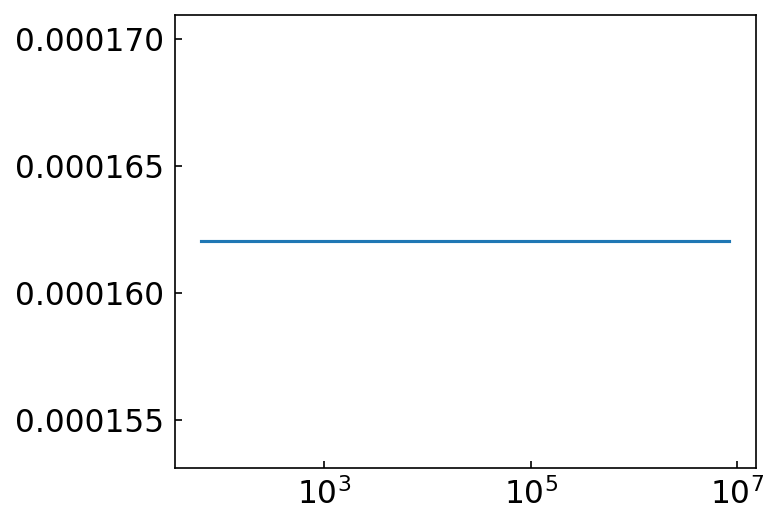

In [50]:
plt.plot(ns,(np.array(masses).astype(np.float16) - np.array(masses).astype(np.float64))/np.array(masses).astype(np.float64))
plt.xscale('log')
plt.show()

In [51]:
error_distance = []
means = []
means2 = []
diffs2 = []
varis = []
xs = []
for i,n in zip(dists,ns):
    dist = i[0]
    f2 = (1/dist.astype(np.float16)).astype(np.float16)
    f8 = (1/dist.astype(np.float64)).astype(np.float64)
    diff = np.abs(np.sum(f8)-np.sum(f2.astype(np.float64)))
    varis.append(np.var(np.abs(1-f2/f8)))
    means.append(np.mean(np.abs(1-f2/f8)))
    #means.append(diff/np.sum(f8))
    #means2.append(np.mean(np.abs(f8-f2)/f8))

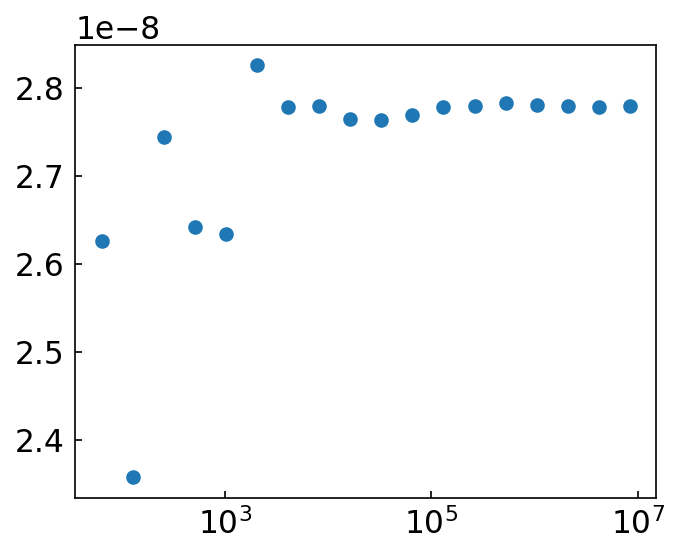

In [52]:
plt.scatter(ns,varis)
plt.xscale('log')
plt.show()

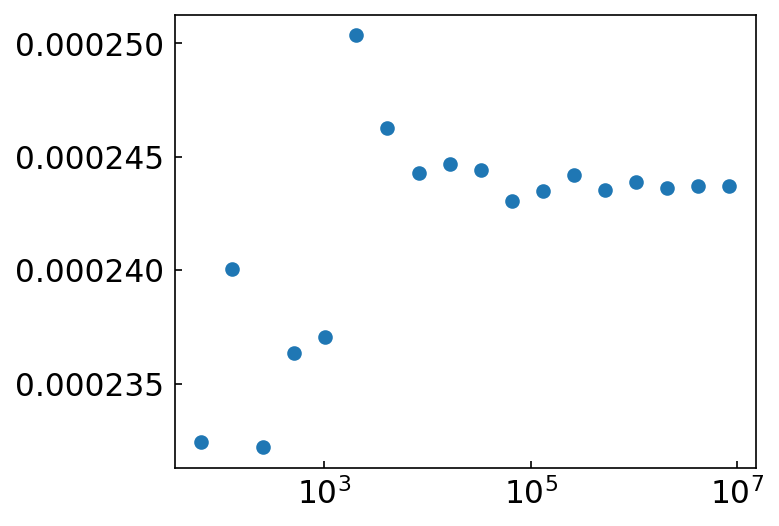

In [53]:
plt.scatter(ns,means)
plt.xscale('log')
plt.show()

In [54]:
error_distance = []
means = []
means2 = []
diffs2 = []
varis = []
xs = []
for i,n,mass in zip(dists,ns,masses):
    dist = i[0]
    f2 = (mass/dist.astype(np.float16)).astype(np.float16)
    f8 = (mass/dist.astype(np.float64)).astype(np.float64)
    diff = np.abs(np.sum(f8)-np.sum(f2.astype(np.float64)))
    varis.append(np.var(np.abs(1-f2/f8)))
    means.append(np.mean(np.abs(1-f2/f8)))
    #means.append(diff/np.sum(f8))
    #means2.append(np.mean(np.abs(f8-f2)/f8))

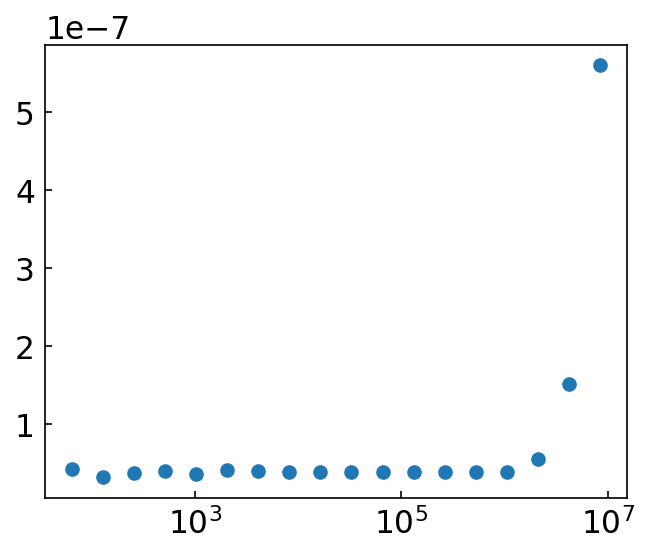

In [55]:
plt.scatter(ns,varis)
plt.xscale('log')
plt.show()

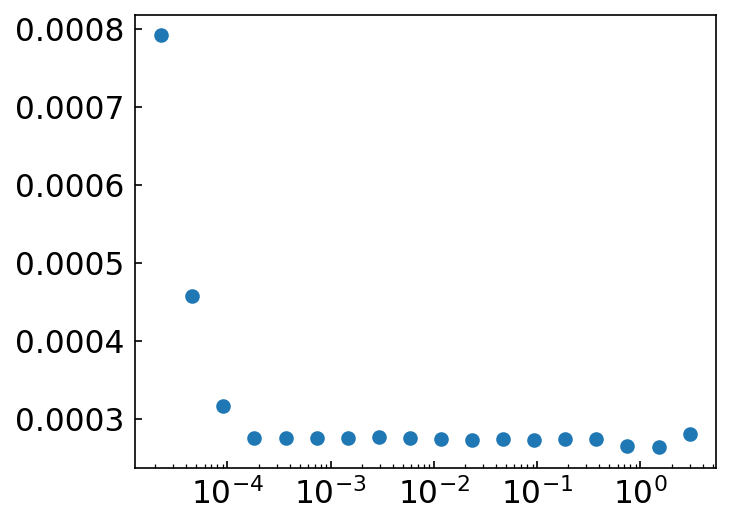

In [56]:
plt.scatter(masses,means)
plt.xscale('log')
plt.show()

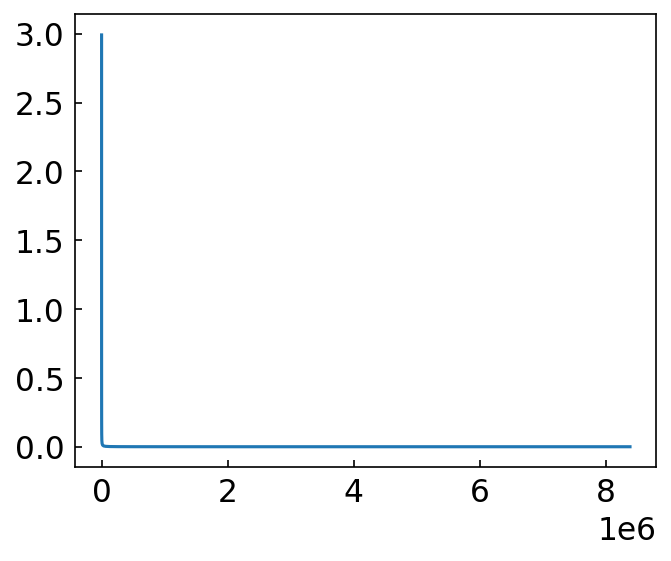

In [58]:
plt.plot(ns,masses)
plt.show()

In [ ]:
plt.plot(ns,masses)
plt.show()